# OrchestrAIt Model Training

This notebook serves as the the proof of concept and basis for OrrchestrAIt's initial workflow. We are using sample documents (which will be redacted to ensure confidentiality) to create a nueral network which can look at a document, label it to be routed correctly. This proof of concept outlines the rough edges of the product, there are several issues that need to be addressed in order to have a fully functioning product for end users. Below shows the initial approach to building a model.

In [1]:
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import tensorflow as tf
import os
import pathlib
import fitz
import logging
import PyPDF2
import shutil
import pickle as pl
from pdf2image import convert_from_path
import nltk
import pytesseract
import cv2

pytesseract.pytesseract.tesseract_cmd =r"C:\Program Files\Tesseract-OCR\tesseract"

In [2]:
def split_pdf_template(input_path, output_prefix, final_output_path):
    with open(input_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)

        for page_number, page in enumerate(pdf_reader.pages, start=1):
            pdf_writer = PyPDF2.PdfWriter()
            pdf_writer.add_page(page)

            output_path = f"{output_prefix}_{page_number}.pdf"
            with open(output_path, 'wb') as output_file:
                pdf_writer.write(output_file)
            shutil.move(output_prefix+"_"+str(page_number)+".pdf", final_output_path)
            logging.info(f"{output_path}_{page_number} saved to {final_output_path}")

In [3]:
actual=r'redacted'
actual_split=r'redacted'

In [4]:
split_pdf_template(actual, 'collateral', actual_split)

In [5]:
def pdf_reader(file):
    read=convert_from_path(file, dpi=400)
    for i in read:
        image=cv2.cvtColor(np.array(i), cv2.COLOR_RGB2BGR)
        # Grayscale, Gaussian blur, Otsu's threshold
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (3,3), 0)
        thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        # Morph open to remove noise and invert image
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        invert = 255 - opening
        text=pytesseract.image_to_string(invert,lang='eng', config='--psm 6')
    text=text.replace('\n',' ')
    return text

In [6]:
training_folder = r'redacted'
pytesseract.pytesseract.tesseract_cmd =r'redacted'

In [216]:
# Create a function to convert all files to pdfs!!

In [7]:
def doc_to_dataframe(path):
    doc_list = [(str(dirpath).replace(path,"").replace("\\",""), name, pdf_reader(pathlib.Path(dirpath,name)))  if name.endswith('.pdf') 
        else (str(dirpath).replace(path,"").replace("\\",""), name, docx_to_text(pathlib.Path(dirpath,name))) if name.endswith('.docx') else None
        for dirpath, subdirs, filenames in os.walk(path) 
            for name in filenames
    ]
    doc_list_df=pd.DataFrame(doc_list, columns=['doc_type', 'doc_name','doc_content'])
    doc_list_df=doc_list_df.dropna()
    return doc_list_df

doc_df = doc_to_dataframe(training_folder)
doc_df.info() # Quick sanity check shows how many documents we have and if there are any empty rows in our dataframe
doc_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_type     358 non-null    object
 1   doc_name     358 non-null    object
 2   doc_content  358 non-null    object
dtypes: object(3)
memory usage: 8.5+ KB


,doc_type,doc_name,doc_content
0,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_133...,pee es Dates 08/30/2005 °° re ooo + £ Pitle No...
1,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_134...,"Soo. 3 BANKRUPTCY SEARCH *) 0 es -"".” “NAME OF..."
2,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_139...,|. Title No. FT120083.(576_Q_4295) a ee : oo M...
3,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_140...,re s+ § 2 os Doecument “Execution Coversheet ‘...
4,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_141...,SUPREME COURT OF THE STATE OF NEW YORK COUNTY ...
5,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_142...,PLAINTIFF’S INTEREST IN THE MORTGAGE. 4. That...
6,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_143...,"“(See Complaint annexed hereto as Exhibit “ "" ..."
7,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_144...,Copies of the loan documents are annexed heret...
8,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_145...,"13. Therefore, Plaintiff has an ownership inte..."
9,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_146...,Sand advances: (See Complaint annesied hereto ...


In [8]:
# Tokenize the text using nltk so that words are evaluated and not individual letters

nltk.download('punkt')  # Download the required resource
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+') # tokenize words

def segment_text(text, max_length):
    tokens = tokenizer.tokenize(text)
    segments = []
    current_segment = []
    for token in tokens:
        current_segment.append(token)
        if len(current_segment) == max_length:
            segments.append(current_segment)
            current_segment = []
    # If there are remaining tokens at the end, add them as the last segment
    if current_segment:
        segments.append(current_segment)
    return segments

[nltk_data] Downloading package punkt to C:\Users\Tim
[nltk_data]     Williams\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# Create a new DataFrame to store segmented text

# Set the sequence length
max_sequence_length = 512
# Initialize an empty DataFrame to store the segmented text
doc_segments_df = pd.DataFrame(columns=['doc_type', 'doc_name', 'doc_content', 'doc_segments'])

# Iterate over each row in the doc_df DataFrame
for index, row in doc_df.iterrows():
    segments = segment_text(row['doc_content'], max_sequence_length)
    
    # Create a new DataFrame for the segments of the current document
    single_doc_segment_df = pd.DataFrame({'doc_type': row['doc_type'],
                                          'doc_name': row['doc_name'],
                                          'doc_content': row['doc_content'],
                                          'doc_segments': [' '.join(segment) for segment in segments]})
    
    # Append the segmented text of the current document to the doc_segments_df DataFrame
    doc_segments_df = pd.concat([doc_segments_df, single_doc_segment_df], ignore_index=True)

In [10]:
doc_segments_df=doc_segments_df.reset_index(drop=True).dropna() #Need a method for validating blank pages
doc_segments_df

,doc_type,doc_name,doc_content,doc_segments
0,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_133...,pee es Dates 08/30/2005 °° re ooo + £ Pitle No...,pee es Dates 08 30 2005 re ooo Pitle No FT1200...
1,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_134...,"Soo. 3 BANKRUPTCY SEARCH *) 0 es -"".” “NAME OF...",Soo 3 BANKRUPTCY SEARCH 0 es NAME OF INDIVIDUA...
2,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_139...,|. Title No. FT120083.(576_Q_4295) a ee : oo M...,Title No FT120083 576_Q_4295 a ee oo Municipal...
3,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_140...,re s+ § 2 os Doecument “Execution Coversheet ‘...,re s 2 os Doecument Execution Coversheet rr ar...
4,Foreclosure,COLFIL-7-18-2016-Loan_7000087964-102130339_141...,SUPREME COURT OF THE STATE OF NEW YORK COUNTY ...,SUPREME COURT OF THE STATE OF NEW YORK COUNTY ...
...,...,...,...,...
563,Title,collateral_82.pdf,Policy Number: LP-22-AL1038-5458023 File Numbe...,Policy Number LP 22 AL1038 5458023 File Number...
564,Title,collateral_83.pdf,Policy Number: LP-22-AL1038-5458023 File Numbe...,Policy Number LP 22 AL1038 5458023 File Number...
565,Title,collateral_84.pdf,Policy Number: LP-22-AL1038-5458023 File Numbe...,Policy Number LP 22 AL1038 5458023 File Number...
566,Title,collateral_85.pdf,Policy Number LP-22-AL1038-5458023 File Number...,Policy Number LP 22 AL1038 5458023 File Number...


In [11]:
doc_segments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   doc_type      568 non-null    object
 1   doc_name      568 non-null    object
 2   doc_content   568 non-null    object
 3   doc_segments  568 non-null    object
dtypes: object(4)
memory usage: 17.9+ KB


In [12]:
seq_len=512
num_samples=len(doc_segments_df)

Xids=np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

Xids.shape

(568, 512)

In [13]:
Xmask.shape

(568, 512)

In [14]:
Xids

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
Xmask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
tokenizer=BertTokenizer.from_pretrained('bert-base-cased')

""" 
Special Tokens
[CLS] - The beginning of a sequence
[SEP] - The separator token, separates different sequences or marks the end of a sequence
[PAD] - padding token - pushes token length to max tokens or truncates to the max length. Needed to train the model as you cannot have uneven amount of tokens.
"""

for i, text in enumerate(doc_segments_df['doc_segments']): # loop through each phrase in the new doc DF
    tokens=tokenizer.encode_plus(text, # single prase to be evaluated
                                 max_length=seq_len, # setting the length of our tokens
                                 truncation=True, # truncate tokens above max tokens
                                 padding='max_length', # add tokens to the max length
                                 add_special_tokens=True,  # use special tokens
                                 return_tensors='tf' # returning tensorflow tensors
        )
    Xids[i, :] = tokens['input_ids'] # determines which line to add data to (i) and then tokenizes the phrases from review and adds them to Xids
    Xmask[i, :] = tokens['attention_mask'] # determines which line to add data to (i) and then tokenizes the phrases from review and adds them to Xmask

In [17]:
tokens

{'input_ids': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
array([[  101,  7037,  7421,  6400,  1659, 18589, 10424, 23249,  4335,
         1571, 18910, 22737, 25647,  7421, 16151,  3190,  5519,  1604,
        25491,  1545,   153, 13901,   172,  8732,  2553,  1106,  1126,
         8331,  1388,  1113,  1103,  4026,  1120, 14265,  1104,  7037,
          178,  1115,  1110,  1388,  1113,  1137,  4035,  1665, 20073,
         1279,  2135,  1115,  3849,  1104,  1103,  4026,  2548,  1106,
         1126,  7166,  1880,  2589,  1174,  1107, 23070,   139,  1134,
         3290,  2686,  1121,  1103,  6730,  1104,  1103,  1268,  1106,
         4731,  1103,  7166,  1880,  1111,  1103,  3007,  1111,  1134,
         1122,  1108,  3609,  1137,  9142,  1137, 25550,  3694,  1121,
         1103,  2174,  6730,  1104,   170,  1268,  1106,  1329,  1103,
         2473,  1104,  1103,  4026,  1111,  1103, 16026,  1137,  1718,
         1104, 15362,  1137,  1251,  1168,  4841,  6385, 11931,  7954,
        15804, 

In [18]:
"""
Noticed how the 0s are gone and replace with tokens (numbers). 101 is the CLS token or the 
start of the phrase. PAD is the padding token shown as 0.
"""
Xids

array([[  101.,   185.,  3051., ...,     0.,     0.,     0.],
       [  101., 27972.,   124., ...,     0.,     0.,     0.],
       [  101., 11772.,  1302., ...,     0.,     0.,     0.],
       ...,
       [  101.,  7037.,  7421., ...,     0.,     0.,     0.],
       [  101.,  7037.,  7421., ..., 20073.,  1880.,   102.],
       [  101.,  7037.,  7421., ...,     0.,     0.,     0.]])

In [19]:
"""
Noticed how the 0s are gone and replace with 1s for attention_mask. This will tell BERT where to pay attention. 
The 0s dont mean anything so they should not be evaluated. BERT should not be taking padding tokens into 
consideration.
"""
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [20]:
"""
Creates a series based on the doc_type value. May need to encode for 
categorical publish_display_data, aka names of templates.
"""
arr=pd.DataFrame(doc_segments_df['doc_type'])
arr

,doc_type
0,Foreclosure
1,Foreclosure
2,Foreclosure
3,Foreclosure
4,Foreclosure
...,...
563,Title
564,Title
565,Title
566,Title


In [21]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(arr['doc_type'])
arr['doc_type_no']=le.transform(arr['doc_type'])

In [22]:
arr.apply(lambda x: x.unique())

,doc_type,doc_type_no
0,Foreclosure,0
1,General,1
2,Mortgage,2
3,Note,3
4,Origination,4
5,Title,5


In [23]:
""""
Creates and array of 0s the length of the number of samples we have.
the width is equal to the number of possible values. In other words,
each location in a single array represents a column for values 0-56 for 
a total of 57 positions. Each location in of the array in the matrix, in this 
case positions 0-156,059, represents each of the reviews in the original dataframe
"""
max_cat=arr.doc_type_no.max()
max_cat
labels=np.zeros((num_samples, max_cat+1))

In [24]:
# 57 possible values for each of the 156,060 reviews
labels.shape

(568, 6)

In [25]:
# We've only instantiated the matrix with 0s so far
labels

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [26]:
""""
This code fills in the matrix with 1s by selecting the row we want (num_samples)
with the column we want (arr which is based on the value of the sentiment).
"""
labels[np.arange(num_samples), arr['doc_type_no']] = 1

In [27]:
print(labels)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [42]:
"""
This will create tensorflow datasets which are similar to arrays?
THey cannot be printed directly because they are generator types.
Can access them by adding '.take(i)'
Notice each item in the triple tuple is represented in the dataset. 
"""

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask,labels))
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [29]:
Xids[0,:].shape

(512,)

In [30]:
Xmask[0,:].shape

(512,)

In [34]:
labels[0,:].shape

(6,)

In [43]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [44]:
dataset=dataset.map(map_func)
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [45]:
"""
GPU needs to be taken into consideration when choosing batch size for processing. 16 is high (4090 FTW!!!)
Always shuffle before batching or youll have weird chunks of data in a somewhat sorted way which we dont want.
We want to ensure training is randomized for the model to learn from. Be sure to drop remainders to ensure 
batch size
"""

batch_size=8
dataset=dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [46]:
# Setting the test and training split sizes. here we want 10% of the data to be a holdout for testing

split=0.8
size=int((num_samples/batch_size)*split)

In [47]:
train_dataset=dataset.take(size)
val_dataset=dataset.skip(size)

del dataset # removing as we no longer need it

In [48]:
from transformers import TFAutoModel
#from keras.saving.hdf5_format import save_attributes_to_hdf5_group

bert=TFAutoModel.from_pretrained('bert-base-uncased')

bert.summary()

c:\Program Files\Python310\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Tim Williams\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [49]:
input_ids=tf.keras.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask=tf.keras.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

embeddings=bert.bert(input_ids, attention_mask=mask)[1]

x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(max_cat+1, activation='softmax', name='outputs')(x)

In [50]:
model=tf.keras.Model(inputs=[input_ids, mask], outputs=y)
# model.layers[2].trainable=False -- Use this if the computer is not strong enough
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [51]:
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss=tf.keras.losses.CategoricalCrossentropy()
accuracy=tf.keras.metrics.CategoricalAccuracy('accuracy')

In [52]:
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

In [53]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

Epoch 1/20
56/56 [==============================] - 405s 7s/step - loss: 1.5020 - accuracy: 0.4129 - val_loss: 1.4870 - val_accuracy: 0.4417
Epoch 2/20
56/56 [==============================] - 404s 7s/step - loss: 1.3857 - accuracy: 0.4710 - val_loss: 1.2707 - val_accuracy: 0.4583
Epoch 3/20
56/56 [==============================] - 405s 7s/step - loss: 1.1963 - accuracy: 0.5513 - val_loss: 1.0813 - val_accuracy: 0.6500
Epoch 4/20
56/56 [==============================] - 407s 7s/step - loss: 1.0227 - accuracy: 0.6295 - val_loss: 1.0238 - val_accuracy: 0.6417
Epoch 5/20
56/56 [==============================] - 406s 7s/step - loss: 0.9286 - accuracy: 0.6540 - val_loss: 0.7656 - val_accuracy: 0.7333
Epoch 6/20
56/56 [==============================] - 403s 7s/step - loss: 0.7880 - accuracy: 0.7411 - val_loss: 0.7049 - val_accuracy: 0.7250
Epoch 7/20
56/56 [==============================] - 402s 7s/step - loss: 0.6027 - accuracy: 0.8259 - val_loss: 0.7045 - val_accuracy: 0.7417
Epoch 8/20
56

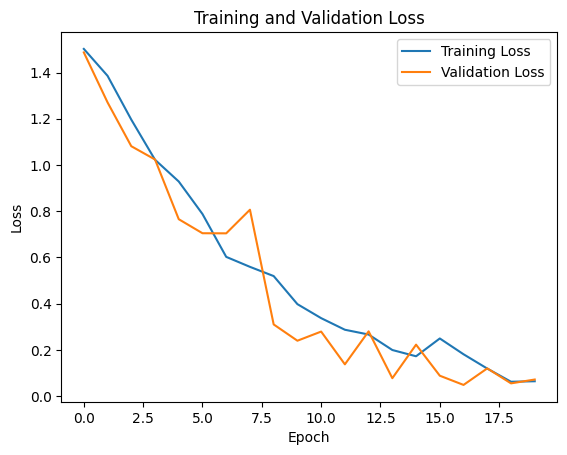

In [56]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

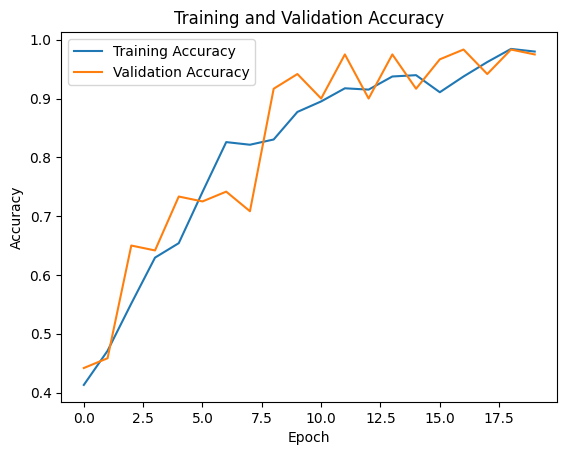

In [57]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [58]:
model.save('mortgage_doc_identifier_v01')

INFO:tensorflow:Assets written to: mortgage_doc_identifier_v01\assets


INFO:tensorflow:Assets written to: mortgage_doc_identifier_v01\assets


# Appendix

Unfinished code from POC

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional

# Define the model architecture
def hierarchical_rnn_model(max_doc_length, max_seq_length, vocab_size):
    # Document-level inputs
    document_input = Input(shape=(max_doc_length, max_seq_length), dtype='int32')
    
    # Word-level inputs within each document
    word_input = Input(shape=(max_seq_length,), dtype='int32')
    
    # Word embedding layer
    embedding = Embedding(input_dim=vocab_size, output_dim=128)
    
    # Word-level LSTM
    word_lstm = Bidirectional(LSTM(64, return_sequences=False))
    
    # Document-level LSTM
    document_lstm = Bidirectional(LSTM(128, return_sequences=False))
    
    # Word-level representation
    word_embedded = embedding(word_input)
    word_encoded = word_lstm(word_embedded)
    
    # Document-level representation
    doc_embedded = embedding(document_input)
    doc_encoded = LSTM(64, return_sequences=True)(doc_embedded)
    doc_encoded = document_lstm(doc_encoded)
    
    # Concatenate word-level and document-level representations
    merged = tf.concat([word_encoded, doc_encoded], axis=-1)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(merged)
    
    # Create the model
    model = tf.keras.Model(inputs=[document_input, word_input], outputs=output)
    
    return model

# Set the maximum document length, sequence length, and vocabulary size
max_doc_length = 10
max_seq_length = 20
vocab_size = 10000

# Create an instance of the hierarchical RNN model
model = hierarchical_rnn_model(max_doc_length, max_seq_length, vocab_size)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit([document_sequences, word_sequences], labels, epochs=10, batch_size=32)

